In [662]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft

X_new,muJ,sdJ = np.loadtxt('Jband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XK_new,muK,sdK = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1,2), unpack=True)

In [727]:
#x = tt.matrix()
#y = tt.matrix()

#veclen = x.shape[1]
#print(veclen)

#conv1d_expr = conv2d(x, y, input_shape=(1, veclen), border_mode='full')

#conv1d = theano.function([x, y], outputs=conv1d_expr)

def findMiddle(input_list):
    if len(input_list) % 2 != 0:
        return (int((len(input_list))/2)-1)
    else:
        return (int((len(input_list)/2)-1)-1,int((len(input_list))/2)-1)
# 1 is subtracted from both because python indicies start at 0 

In [763]:
def Middlearray(input_list, data):
    mid = findMiddle(input_list)
    
    if isinstance(mid, int) == False:#if there is two mid values
        li = input_list
        limid=li[int(mid[0]-(len(data)/2)):mid[0]]
        limid2 = li[mid[1]:int(mid[1]+(len(data)/2))]
        convsame=np.hstack((limid,limid2))
    else:#if there is one mid value 
        li = input_list 
        convsame = li[int(mid-(len(data)/2)):int(mid+(len(data)/2))]
        
    
    if len(convsame) == len(data):
        return convsame
    else:
        return -inf


In [773]:
li = np.linspace(0,1,100)
li2 = np.linspace(0,1,50)

#len(Middlearray(li,li2))
mid=findMiddle(li)
print(mid)
isinstance(mid, int)
#np.reshape(findMiddle(li),1).shape

(48, 49)


False

In [804]:
import theano
import theano.tensor as tt
from theano.tensor.nnet import conv
import lasagne

wav = 5000.0#np.linspace(10,10000,100)
wav_0 = 5000.0

from scipy import signal
#sig = np.repeat([0., 1., 0.], 100)
#win = signal.hann(50)
#filtered = signal.convolve(sig, win, mode='same') / sum(win)


with pm.Model() as convmodel:
    
    # Define priors
    sigma_DT=pm.Uniform('sigma_DT', lower=-7.0, upper=2.0)
    sigma_AD=pm.Uniform('sigma_AD', lower=-7.0, upper=2.0)
    mu_DT=pm.Uniform('mu_DT', lower=2.7, upper=4.0)
    mu_AD=pm.Uniform('mu_AD', lower=0.0, upper=2.3)
    A_T=pm.Uniform('A_T', lower=0.0, upper=1.0)
    T=pm.Uniform('T', lower=1300.0, upper=1700.0)
    K_0=pm.Uniform('K_0', lower=0, upper=10.0)
    index=pm.Uniform('index', lower=-10.0, upper=0.0)
   
    h = 6.626e-34#Plancks constant
    c = 299792458#speed of light
    k = 1.38e-23#Boltzmanns constant
    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    BB = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    exp_DT = -((tt.log(XK_new)-mu_DT)**2/(2*sigma_DT**2))
    front_DT = A_T/(XK_new*sigma_DT*np.sqrt(2*np.pi))
    Psi_DT = BB*front_DT*np.exp(exp_DT)
    powr = K_0*(wav/wav_0)**(index)
    exp_AD = -((tt.log(XK_new)-mu_AD)**2/(2*sigma_AD**2))
    front_AD = (1.0-A_T)/(XK_new*sigma_AD*np.sqrt(2*np.pi))
    Psi_AD = powr*front_AD*tt.exp(exp_AD)
    transfer = Psi_DT + Psi_AD
    
    #print(transfer.eval({T:XK_new}))
    #print(tt.ones(tt.shape(transfer)[0]))
    
    muJL = len(muJ)
    muJS = theano.shared(value=muJ)
    conv2d = theano.tensor.nnet.conv2d

    #conv1d = conv2d([muJ,muJL,1,1],[transfer,muJL,1,1] ,border_mode='full')
    #conv1d= np.convolve(transfer,muJ,'same')
    conv1d=signal.convolve(muJS, transfer, mode='same') #/ sum(transfer)
    print(conv1d)
    #print(conv1d.eval())
    
    likelihood = pm.Normal('muK', mu=conv1d, sigma=sdK, observed=muK)

    tracetransfer = pm.sample(2000)

Elemwise{mul,no_inplace}.0


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [index, K_0, T, A_T, mu_AD, mu_DT, sigma_AD, sigma_DT]
INFO:pymc3:NUTS: [index, K_0, T, A_T, mu_AD, mu_DT, sigma_AD, sigma_DT]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:15<00:00, 132.27draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4D887DC18>,
      dtype=object)

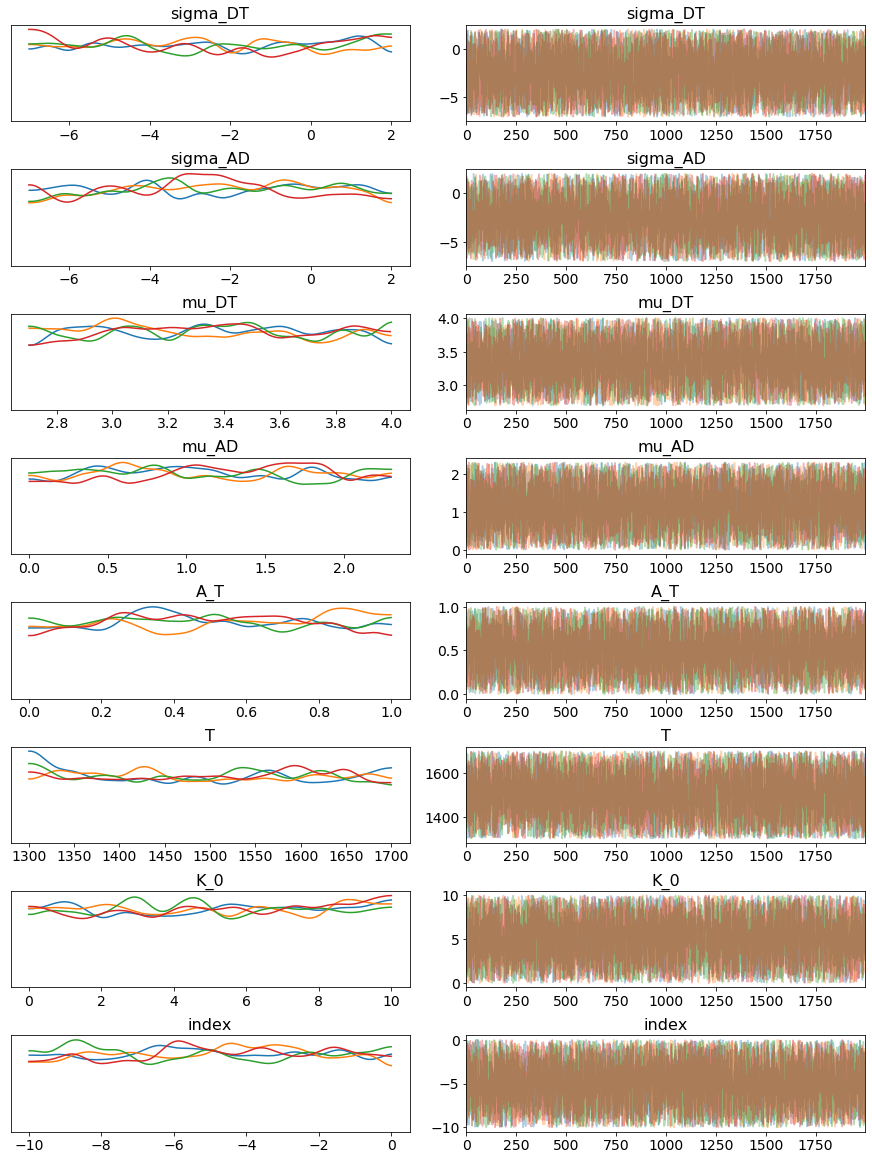

In [805]:
pm.traceplot(tracetransfer)

# All of this stuff below is just for looking at the transfer function and using MCMC hammer instead

In [607]:
def log_likelihood(theta, x, y, Fc, yerr):
    sigma_DT, sigma_AD, mu_DT, mu_AD, A_T, T, wav, wav_0, K_0, index, log_f = theta
    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav=1e-9*np.exp(wav)#convert wavelength to meters
    wav_0 = 1e-9*np.exp(wav_0)#convert reference wavelength to meters 
    x=86400.0*x#convert time in day to seconds 
    T=np.exp(T)#go from log value to linear value 
    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    BB = a/ ( (wav**5) * (np.exp(b) - 1.0) )#planck function 
    exp_DT = -((np.log(x)-mu_DT)**2/(2*sigma_DT**2))#exponential for lognormal
    front_DT = A_T/(x*sigma_DT*np.sqrt(2*np.pi))#front part of lognormal
    norm_DT = h**5*c**3/(k**6*T**6)#normalization to get Psi_DT unitless
    Psi_DT = norm_DT*BB*front_DT*np.exp(exp_DT)#Dusty torus transfer function
    
    powr = K_0*(wav/wav_0)**(index)
    exp_AD = -((np.log(x)-mu_AD)**2/(2*sigma_AD**2))
    front_AD = (1.0-A_T)/(x*sigma_AD*np.sqrt(2*np.pi))
    Psi_AD = powr*front_AD*np.exp(exp_AD)
    
    transfer = (Psi_DT + Psi_AD)
    
    model = np.convolve(transfer, Fc,'same')
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

In [639]:
from scipy.optimize import minimize

sigma_DT_val=1.0#0.04
sigma_AD_val=1.0#0.04
mu_DT_val=5.5#5.5
mu_AD_val=2.2#2.4
A_T_val=0.5
T_val=np.log(1800.0)
wav_val=np.log(2500.0)#10.0
wav_0_val=np.log(2500.0)#100.0
K_0_val=1.0
index_val=-2.0
log_f_val=-0.70#variance is underestimated by some fractional amout f
param=11

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([sigma_DT_val, sigma_AD_val, mu_DT_val, mu_AD_val, A_T_val, T_val, wav_val, wav_0_val, K_0_val, index_val, log_f_val]) + 0.01*np.random.randn(param)
soln = minimize(nll, initial, args=(XK_new, muK, muJ, sdK))
sigma_DT_ml, sigma_AD_ml, mu_DT_ml, mu_AD_ml, A_T_ml, T_ml, wav_ml, wav_0_ml, K_0_ml, index_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print(soln.x)
  

Maximum likelihood estimates:
[ 1.00496714  0.99861736  5.50647689  2.2152303   0.49765847  7.49320057
  7.83983814  7.83172036  0.99530526 -1.9945744  -0.70463418]


In [640]:
def Psitot(theta, x, y, Fc, yerr):
    sigma_DT, sigma_AD, mu_DT, mu_AD, A_T, T, wav, wav_0, K_0, index, log_f = theta
    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav=1e-9*np.exp(wav)#convert wavelength to meters
    wav_0 = 1e-9*np.exp(wav_0)#convert reference wavelength to meters 
    x=86400.0*x#convert time in day to seconds 
    T=np.exp(T)#go from log value to linear value 
    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    BB = a/ ( (wav**5) * (np.exp(b) - 1.0) )#planck function 
    exp_DT = -((np.log(x)-mu_DT)**2/(2*sigma_DT**2))#exponential for lognormal
    front_DT = A_T/(x*sigma_DT*np.sqrt(2*np.pi))#front part of lognormal
    norm_DT = h**5*c**3/(k**6*T**6)#normalization to get Psi_DT unitless
    Psi_DT = norm_DT*BB*front_DT*np.exp(exp_DT)#Dusty torus transfer function
    
    powr = K_0*(wav/wav_0)**(index)#power law
    exp_AD = -((np.log(x)-mu_AD)**2/(2*sigma_AD**2))#exponential for lognormal
    front_AD = (1.0-A_T)/(x*sigma_AD*np.sqrt(2*np.pi))#front of lognormal
    Psi_AD = powr*front_AD*np.exp(exp_AD)#Accretion disk transfer function
    
    transfer = (Psi_DT + Psi_AD)
    
    model = np.convolve(transfer, Fc,'same')
    return model

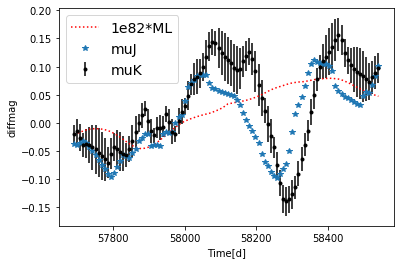

In [641]:
conv = Psitot(soln.x, XK_new, muK, muJ, sdK)

plt.errorbar(XK_new, muK, yerr=sdK, fmt=".k", capsize=0, label='muK')
plt.plot(XK_new, 1e82*conv, ":r", label="1e82*ML")
plt.plot(XK_new, muJ, '*', label="muJ")
plt.legend(fontsize=14)
#plt.xlim(58240,58290)
plt.xlabel("Time[d]")
plt.ylabel("diffmag");

In [613]:
#define the prior 

def log_prior(theta):
    sigma_DT, sigma_AD, mu_DT, mu_AD, A_T, T, wav, wav_0, K_0, index, log_f = theta
    if (0.0 < sigma_DT < 3.5 and 0.0 < sigma_AD < 3.5 and 0.0 < mu_DT < 7.0
        and 0 < mu_AD < 7.0 and 0.0 < A_T < 1.0 and np.log(1300.0) < T < np.log(2000.0) and 0.0 < wav < np.log(6000.0)
        and 0.0 < wav_0 < np.log(6000.0) and 0.0 < K_0 < 10.0 and -3.0 < index < 0.0 and -5.0 < log_f < 0.0):
        return 0.0
    return -np.inf

In [614]:
def log_probability(theta, x, y, Fc, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, Fc, yerr)

In [615]:
import emcee
#sigma_DT_val, sigma_AD_val, mu_DT_val, mu_AD_val, A_T_val, T_val, wav_val, wav_0_val, K_0_val, index_val, log_f_val = soln.x
pos = soln.x + 1e-1 * np.random.randn(100, 11)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(XK_new, muK, muJ, sdK))
sampler.run_mcmc(pos, 10000, progress=True);

C:\Users\Ejer\Anaconda3\lib\site-packages\emcee-3.0rc2-py3.7.egg\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 10000/10000 [03:08<00:00, 52.96it/s]


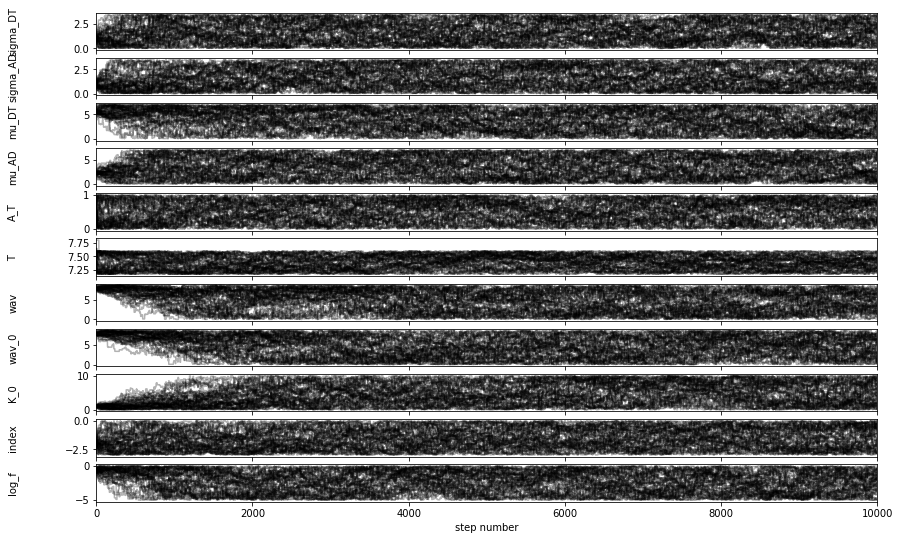

In [616]:
fig, axes = plt.subplots(11, figsize=(14, 9), sharex=True)
samples = sampler.get_chain()
labels = ["sigma_DT", "sigma_AD", "mu_DT", "mu_AD", "A_T", "T", "wav", "wav_0", "K_0", "index", "log_f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [617]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [655.28313031 745.83133868 640.8806086  731.76407013 592.74828582
 650.77891596 699.27783253 700.81311436 746.63175133 693.53101369
 681.74346724]

In [618]:
flat_samples = sampler.get_chain(discard=1200, thin=300, flat=True)
print(flat_samples.shape)

(1450, 11)


In [619]:
planck(wav_ml,T_ml)

50096286522.72329

In [620]:
transferDT(XK_new,mu_DT_ml,sigma_DT_ml,A_T_ml,wav_ml,T_ml)

array([4.17201163e-84, 4.16104798e-84, 4.15011468e-84, 4.13921165e-84,
       4.12833878e-84, 4.11749599e-84, 4.10668321e-84, 4.09590033e-84,
       4.08514727e-84, 4.07442395e-84, 4.06373027e-84, 4.05306616e-84,
       4.04243153e-84, 4.03182628e-84, 4.02125034e-84, 4.01070363e-84,
       4.00018604e-84, 3.98969751e-84, 3.97923795e-84, 3.96880727e-84,
       3.95840539e-84, 3.94803222e-84, 3.93768769e-84, 3.92737171e-84,
       3.91708419e-84, 3.90682505e-84, 3.89659422e-84, 3.88639161e-84,
       3.87621713e-84, 3.86607071e-84, 3.85595227e-84, 3.84586172e-84,
       3.83579898e-84, 3.82576398e-84, 3.81575663e-84, 3.80577685e-84,
       3.79582456e-84, 3.78589968e-84, 3.77600214e-84, 3.76613186e-84,
       3.75628874e-84, 3.74647273e-84, 3.73668373e-84, 3.72692168e-84,
       3.71718648e-84, 3.70747807e-84, 3.69779637e-84, 3.68814130e-84,
       3.67851278e-84, 3.66891074e-84, 3.65933510e-84, 3.64978578e-84,
       3.64026271e-84, 3.63076581e-84, 3.62129501e-84, 3.61185023e-84,
      

In [621]:
power(wav_ml,wav_0_ml,K_0_ml,index_ml)

0.9793195191915959

In [622]:
transferAD(XK_new,mu_AD_ml,sigma_AD_ml,A_T_ml,wav_ml,wav_0_ml,K_0_ml,index_ml)

array([3.14313325e-99, 3.13323271e-99, 3.12336476e-99, 3.11352928e-99,
       3.10372616e-99, 3.09395529e-99, 3.08421656e-99, 3.07450986e-99,
       3.06483507e-99, 3.05519210e-99, 3.04558083e-99, 3.03600115e-99,
       3.02645295e-99, 3.01693613e-99, 3.00745058e-99, 2.99799619e-99,
       2.98857285e-99, 2.97918046e-99, 2.96981892e-99, 2.96048810e-99,
       2.95118792e-99, 2.94191827e-99, 2.93267904e-99, 2.92347012e-99,
       2.91429142e-99, 2.90514283e-99, 2.89602425e-99, 2.88693557e-99,
       2.87787669e-99, 2.86884752e-99, 2.85984794e-99, 2.85087786e-99,
       2.84193718e-99, 2.83302579e-99, 2.82414360e-99, 2.81529051e-99,
       2.80646641e-99, 2.79767121e-99, 2.78890481e-99, 2.78016711e-99,
       2.77145802e-99, 2.76277743e-99, 2.75412524e-99, 2.74550137e-99,
       2.73690571e-99, 2.72833817e-99, 2.71979866e-99, 2.71128707e-99,
       2.70280331e-99, 2.69434729e-99, 2.68591890e-99, 2.67751807e-99,
       2.66914469e-99, 2.66079867e-99, 2.65247992e-99, 2.64418834e-99,
      

In [645]:
exp = -(np.log(XK_new-mu_AD_ml)**2/(2*sigma_AD_ml**2))
print(np.exp(exp))
front = (1.0-A_T_ml)/(XK_new*sigma_AD_ml*np.sqrt(2*np.pi))
print(front)
#print(np.exp(exp)*front)

[6.76492759e-27 6.75385352e-27 6.74279908e-27 6.73176423e-27
 6.72074892e-27 6.70975313e-27 6.69877681e-27 6.68781993e-27
 6.67688245e-27 6.66596433e-27 6.65506554e-27 6.64418604e-27
 6.63332579e-27 6.62248476e-27 6.61166290e-27 6.60086020e-27
 6.59007659e-27 6.57931206e-27 6.56856656e-27 6.55784006e-27
 6.54713252e-27 6.53644391e-27 6.52577419e-27 6.51512332e-27
 6.50449126e-27 6.49387799e-27 6.48328347e-27 6.47270765e-27
 6.46215051e-27 6.45161201e-27 6.44109212e-27 6.43059079e-27
 6.42010800e-27 6.40964370e-27 6.39919787e-27 6.38877046e-27
 6.37836145e-27 6.36797080e-27 6.35759846e-27 6.34724442e-27
 6.33690863e-27 6.32659106e-27 6.31629168e-27 6.30601044e-27
 6.29574732e-27 6.28550228e-27 6.27527528e-27 6.26506630e-27
 6.25487530e-27 6.24470224e-27 6.23454710e-27 6.22440982e-27
 6.21429040e-27 6.20418878e-27 6.19410493e-27 6.18403883e-27
 6.17399043e-27 6.16395971e-27 6.15394662e-27 6.14395115e-27
 6.13397325e-27 6.12401289e-27 6.11407003e-27 6.10414465e-27
 6.09423672e-27 6.084346

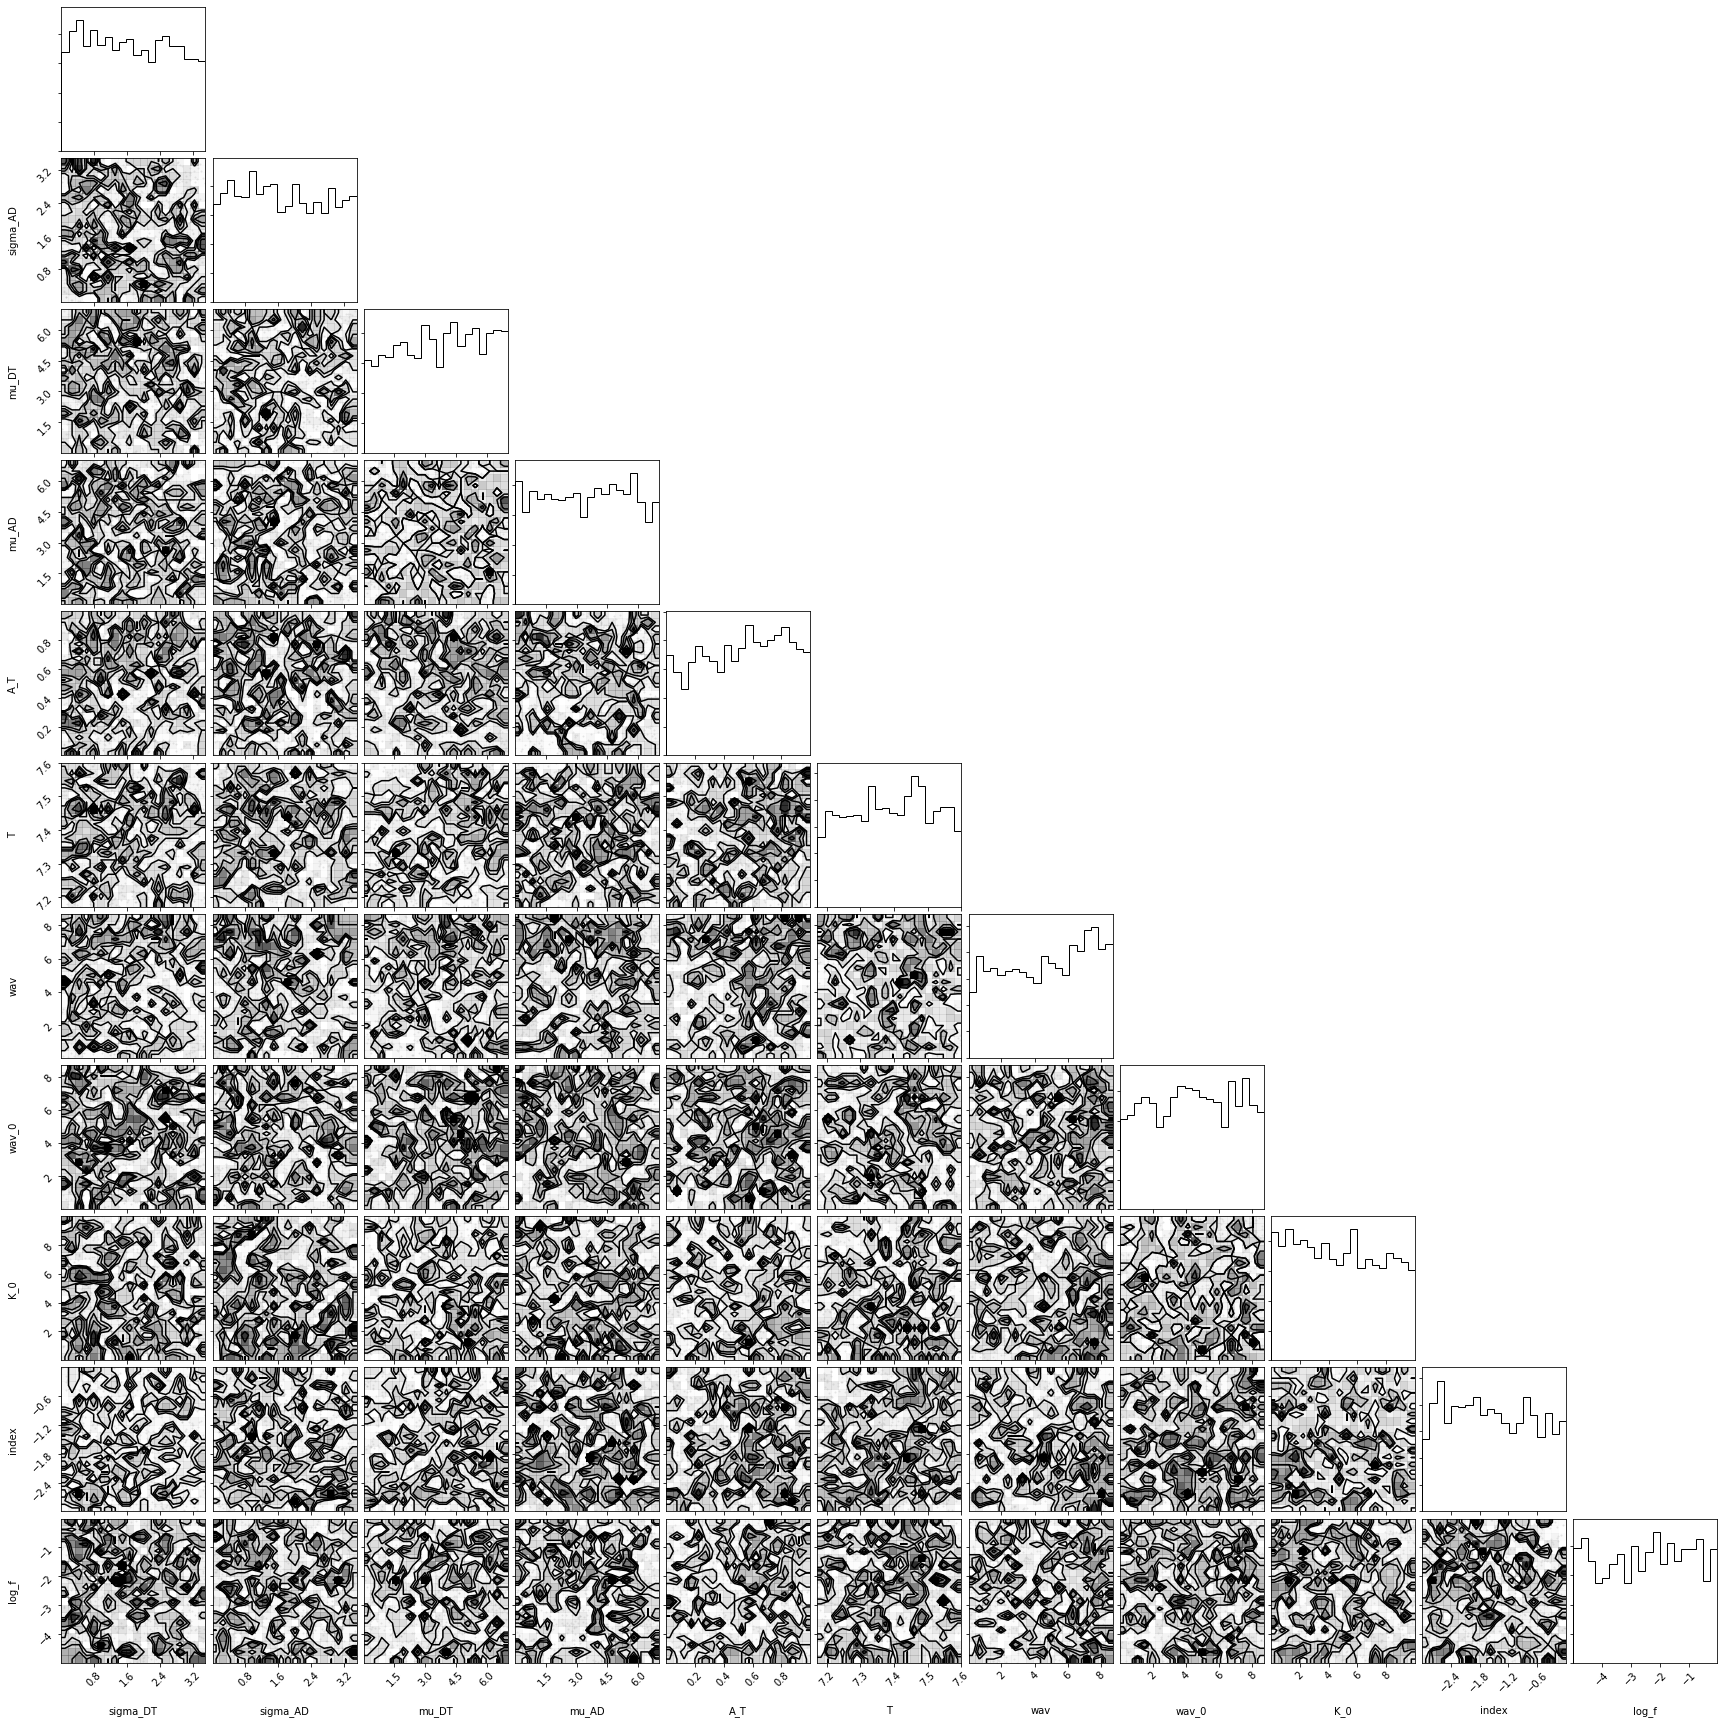

In [626]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);